In [ ]:
# 시작, 위 코드들은 다른 로딩 등에 사용 위함이므로  # ====...=== 있는곳부터 봐도 무방함.
# 단, pc환경에서 실험시 모두 실행해야함

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import numpy as np
import cv2

# 시각화 라이브러리, 몰라도 됨
# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# 마찬가지로 시각화용
# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

In [4]:
#@title Helper functions for visualization
# 시각화 코드

# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

def to_gif(images, duration):
  """Converts image sequence (4D numpy array) to gif."""
  imageio.mimsave('./animation.gif', images, duration=duration)
  return embed.embed_file('./animation.gif')

def progress(value, max=100):
  return HTML("""
      <progress
          value='{value}'
          max='{max}',
          style='width: 100%'
      >
          {value}
      </progress>
  """.format(value=value, max=max))

In [6]:
# movenet 가져오고 입력 이미지에서 좌표 뽑는 곳, pc 테스트용

# get movenet
model_name = "movenet_lightning" #@param ["movenet_lightning", "movenet_thunder", "movenet_lightning_f16.tflite", "movenet_thunder_f16.tflite", "movenet_lightning_int8.tflite", "movenet_thunder_int8.tflite"]

if "tflite" in model_name:
  if "movenet_lightning_f16" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/float16/4?lite-format=tflite
    input_size = 192
  # elif "movenet_thunder_f16" in model_name:
  #   !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/float16/4?lite-format=tflite
  #   input_size = 256
  elif "movenet_lightning_int8" in model_name:
    !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/lightning/tflite/int8/4?lite-format=tflite
    input_size = 192
  # elif "movenet_thunder_int8" in model_name:
  #   !wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/tflite/int8/4?lite-format=tflite
  #   input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_path="model.tflite")
  interpreter.allocate_tensors()

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    # TF Lite format expects tensor type of uint8.
    input_image = tf.cast(input_image, dtype=tf.uint8)
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
    # Invoke inference.
    interpreter.invoke()
    # Get the model prediction.
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    return keypoints_with_scores

else:
  if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
  elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
  else:
    raise ValueError("Unsupported model name: %s" % model_name)

  def movenet(input_image):
    """Runs detection on an input image.

    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.

    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

In [ ]:
# 좌표 뽑는 곳
# 지금부터 보면 됨
# =====================================================================================================================================================

Processing golfDB_test/tst/field/test_finish.png


2024-09-11 15:44:57.388448: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726037097.457304  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.487275  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.495905  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.504623  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.520344  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.529927  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.538793  368701 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726037097.635517  368701 gpu_t

keypoints_json_data [{'person': 4, 'Keypoints': [{'Keypoint ID': 1, 'Y': 0.09638454020023346, 'X': 0.5635105967521667, 'Confidence Score': 0.4908846616744995}, {'Keypoint ID': 2, 'Y': 0.08297358453273773, 'X': 0.563285231590271, 'Confidence Score': 0.3881162405014038}, {'Keypoint ID': 3, 'Y': 0.08513303101062775, 'X': 0.5562506914138794, 'Confidence Score': 0.59454345703125}, {'Keypoint ID': 4, 'Y': 0.09068062156438828, 'X': 0.5267702341079712, 'Confidence Score': 0.2578199803829193}, {'Keypoint ID': 5, 'Y': 0.09733521938323975, 'X': 0.5115228295326233, 'Confidence Score': 0.5755913853645325}, {'Keypoint ID': 6, 'Y': 0.1743897646665573, 'X': 0.4825129210948944, 'Confidence Score': 0.41419970989227295}, {'Keypoint ID': 7, 'Y': 0.17588871717453003, 'X': 0.5116885900497437, 'Confidence Score': 0.4426056146621704}, {'Keypoint ID': 8, 'Y': 0.22008292376995087, 'X': 0.4268077611923218, 'Confidence Score': 0.26472049951553345}, {'Keypoint ID': 9, 'Y': 0.21989183127880096, 'X': 0.4332578778266

/tmp/ipykernel_367681/1830362264.py:163: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)


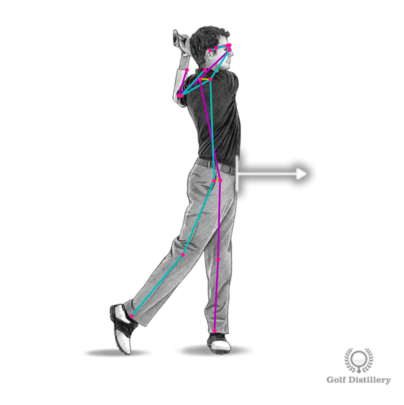

keypoints_json_data [{'person': 4, 'Keypoints': [{'Keypoint ID': 1, 'Y': 0.09638454020023346, 'X': 0.5635105967521667, 'Confidence Score': 0.4908846616744995}, {'Keypoint ID': 2, 'Y': 0.08297358453273773, 'X': 0.563285231590271, 'Confidence Score': 0.3881162405014038}, {'Keypoint ID': 3, 'Y': 0.08513303101062775, 'X': 0.5562506914138794, 'Confidence Score': 0.59454345703125}, {'Keypoint ID': 4, 'Y': 0.09068062156438828, 'X': 0.5267702341079712, 'Confidence Score': 0.2578199803829193}, {'Keypoint ID': 5, 'Y': 0.09733521938323975, 'X': 0.5115228295326233, 'Confidence Score': 0.5755913853645325}, {'Keypoint ID': 6, 'Y': 0.1743897646665573, 'X': 0.4825129210948944, 'Confidence Score': 0.41419970989227295}, {'Keypoint ID': 7, 'Y': 0.17588871717453003, 'X': 0.5116885900497437, 'Confidence Score': 0.4426056146621704}, {'Keypoint ID': 8, 'Y': 0.22008292376995087, 'X': 0.4268077611923218, 'Confidence Score': 0.26472049951553345}, {'Keypoint ID': 9, 'Y': 0.21989183127880096, 'X': 0.4332578778266

In [7]:
# pc에서 입력 이미지의 좌표 뽑는 곳
# json으로 결과 값 저장한다

import csv
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the input size expected by the model
input_size = 192  # Example input size, adjust based on your model's requirement
keypoints_json_data = []

# Function to run inference on a single image
def process_image(image_path, id):
    print(f"Processing {image_path}")

    # Load and preprocess the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)

    # Resize and pad the image to fit the model's expected input size
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # Run model inference
    keypoints_with_scores = movenet(input_image)

    # Convert keypoints_with_scores tensor to a NumPy array and ensure type is float
    keypoints_with_scores_np = keypoints_with_scores.astype(float)

    # Define the base output file name
    base_filename = "golfDB_test/answer_data" #os.path.splitext(os.path.basename(image_path))[0]


    for person_id, person in enumerate(keypoints_with_scores_np[0]):
        person_data = {"person": id + 1, "Keypoints": []}
        for keypoint_id, keypoint in enumerate(person):
            keypoint_data = {
                "Keypoint ID": keypoint_id + 1,
                "Y": float(keypoint[0]),
                "X": float(keypoint[1]),
                "Confidence Score": float(keypoint[2])
            }
            person_data["Keypoints"].append(keypoint_data)
        keypoints_json_data.append(person_data)
    print("keypoints_json_data",keypoints_json_data)


    # Visualize the predictions on the image
    display_image = tf.expand_dims(image, axis=0)
    display_image = tf.cast(tf.image.resize_with_pad(display_image, 1280, 1280), dtype=tf.int32)
    output_overlay = draw_prediction_on_image(np.squeeze(display_image.numpy(), axis=0), keypoints_with_scores)
    plt.figure(figsize=(5, 5))
    plt.imshow(output_overlay)
    plt.axis('off')
    plt.show()

    # print(f'Keypoints have been saved to {output_csv_path}, {output_txt_path}, and {output_json_path}')


# 입력 이미지 주소
image_path = "golfDB_test/tst/field/test_finish.png"
process_image(image_path,3)

# 결과 값,  person은 상관없음 내부 keypoints가 중요
print("keypoints_json_data",keypoints_json_data)

# 결과 값 json에 저장
with open('golfDB_test/test_finish.json', 'w') as json_file:
        json.dump(keypoints_json_data, json_file, indent=4)


In [ ]:
# get model

In [8]:
# 실제 사용할 머신러닝 모델 호출

import numpy as np
import json
import tensorflow as tf

# .tflite 모델 호출
interpreter = tf.lite.Interpreter(model_path="pose_classifier_8.tflite")
interpreter.allocate_tensors()

# Get input and output tensors details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 첫번째 레이어
print(f"input_details {input_details}")

# 마지막 레이어 
print(f"output_details {output_details}")


input_details [{'name': 'serving_default_keras_tensor_378:0', 'index': 0, 'shape': array([ 1, 34], dtype=int32), 'shape_signature': array([-1, 34], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
output_details [{'name': 'StatefulPartitionedCall_1:0', 'index': 10, 'shape': array([1, 4], dtype=int32), 'shape_signature': array([-1,  4], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
# inference

In [11]:
# 실제 추론 코드

def normalize_pose_data(pose_data, reference_x=0.5572794732116567, reference_y=0.1998999040023779):
    normalized_data = []
    outliers = {}
    
    for pose_index, pose in enumerate(pose_data):
        keypoints = pose['Keypoints']
        nose_point = keypoints[0]  # 첫 번째 좌표(코)
        
        # 코 좌표를 기준 좌표로 이동하기 위한 오프셋 계산
        offset_x = reference_x - nose_point['X']
        offset_y = reference_y - nose_point['Y']

        # 이동 후 0 ~ 1 밖으로 벗어날 경우 (이상치 발생) x, y 중 어디서 얼마나 벗어나는지 확인용
        pose_outliers = {'X': 0, 'Y': 0, 'dirx':0, 'diry': 0}
        # 이상치 체크용
        has_outliers = False
        
        # 모든 좌표에 대해 오프셋 적용 및 이상치 확인
        for keypoint in keypoints:
            new_x = keypoint['X'] + offset_x
            new_y = keypoint['Y'] + offset_y

            # 이상 있을 경우 오류값 더하고 이상치 발생 체크
            # 이상치가 여러개면 오륙밧들이 합쳐서 나옵니다.
            if new_x < 0:
                pose_outliers['X'] += 1
                pose_outliers['dirx'] += new_x
                has_outliers = True
            if new_x > 1:
                pose_outliers['X'] += 1
                pose_outliers['dirx'] += new_x
                has_outliers = True
            if new_y < 0:
                pose_outliers['Y'] += 1
                pose_outliers['diry'] += new_y
                has_outliers = True
            if new_y > 1:
                pose_outliers['Y'] += 1
                pose_outliers['diry'] += new_y
                has_outliers = True
            
            keypoint['X'] = new_x
            keypoint['Y'] = new_y

        # 모든 17개의 좌표 확인하여 이상치 없을떄만 저장
        if not has_outliers:
            normalized_data.append(pose)
        # 이상치 ㅈ존재시 이상치 저장소에 저장
        else:
            outliers[pose_index] = pose_outliers
    
    return normalized_data, outliers

# json 로드용
def load_keypoints_from_json(json_file):
    with open(json_file, 'r') as file:
        data = json.load(file)
    return data

# json 파일 주소
json_file = 'golfDB_test/test_finish.json' #'keypoints4.json'

# 관절 좌표 로드
keypoints_data = load_keypoints_from_json(json_file)
print(f"Loaded keypoints data: {keypoints_data}")

# 입력 특징 전처리 > x, y를 정렬해야함 (코 위치로 이동해야 함)
# 각 reference_x, reference_y 변경 금지, 문제있으면 알려주세요 (reference 위치는 고정할 코 위치)
def preprocess_keypoints(keypoints_data, reference_x=0.5572794732116567, reference_y=0.1998999040023779):
    X = []

    # 좌표 정렬 코드
    normalized_data, outliers = normalize_pose_data(keypoints_data, reference_x, reference_y)

    # 
    for entry in normalized_data:
        keypoints = entry["Keypoints"]
        
        # Extract X and Y coordinates for each keypoint
        x_coords = [kp["X"] for kp in keypoints]
        y_coords = [kp["Y"] for kp in keypoints]
        
        # 두 x, y 좌표 값들을 한 개의 특징 벡터로 변형
        # 하나의 리스트에 x 17개 y17개 순차적으로 연결
        features = x_coords + y_coords
        print()
        print("features",features,type(features))
        X.append(features)
    
    return np.array(X)

# 관절 좌표 전처리 ()
X_data = preprocess_keypoints(keypoints_data)
print(f"Processed features: {X_data}")

# 실제 추론
def run_inference(model_interpreter, input_data):
    # Set the input tensor (shape should match the model's input)
    input_data = np.array(input_data, dtype=np.float32)

    # For each keypoints entry (batch size = 1 for each pose)
    # 각 입력 데이터 리스트의 원소들이 하나의 포즈 구성
    for i, input_vector in enumerate(input_data):
        # 입력 텐서
        interpreter.set_tensor(input_details[0]['index'], [input_vector])
        
        # 추론
        interpreter.invoke()

        # 추론 값 받기
        output_data = interpreter.get_tensor(output_details[0]['index'])
        predicted_pose = np.argmax(output_data)  # Predicted class (pose)

        # 확률로 변환
        predicted_probability = np.max(output_data)  # Confidence score

        # 각 포즈일 확률
        print("output_data",output_data)
        # Predicted Pose ID가 예측한 포즈, Probability는 해당 포즈일 확률
        print(f" Predicted Pose ID = {predicted_pose}, Probability = {predicted_probability}")

# 전처리 된 데이터로 추론하기
run_inference(interpreter, X_data)

Loaded keypoints data: [{'person': 4, 'Keypoints': [{'Keypoint ID': 1, 'Y': 0.09638454020023346, 'X': 0.5635105967521667, 'Confidence Score': 0.4908846616744995}, {'Keypoint ID': 2, 'Y': 0.08297358453273773, 'X': 0.563285231590271, 'Confidence Score': 0.3881162405014038}, {'Keypoint ID': 3, 'Y': 0.08513303101062775, 'X': 0.5562506914138794, 'Confidence Score': 0.59454345703125}, {'Keypoint ID': 4, 'Y': 0.09068062156438828, 'X': 0.5267702341079712, 'Confidence Score': 0.2578199803829193}, {'Keypoint ID': 5, 'Y': 0.09733521938323975, 'X': 0.5115228295326233, 'Confidence Score': 0.5755913853645325}, {'Keypoint ID': 6, 'Y': 0.1743897646665573, 'X': 0.4825129210948944, 'Confidence Score': 0.41419970989227295}, {'Keypoint ID': 7, 'Y': 0.17588871717453003, 'X': 0.5116885900497437, 'Confidence Score': 0.4426056146621704}, {'Keypoint ID': 8, 'Y': 0.22008292376995087, 'X': 0.4268077611923218, 'Confidence Score': 0.26472049951553345}, {'Keypoint ID': 9, 'Y': 0.21989183127880096, 'X': 0.4332578778

In [ ]:
# 0.9011462330818176